# Hotel Recommendation System with Hotel Tags

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import warnings
import tensorflow as tf
import seaborn as sns
import math
import sys
from math import sqrt

from tensorflow.keras.layers import *
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Embedding, Flatten, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input, Reshape, Dot
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import roc_curve, accuracy_score
from sklearn.metrics import roc_auc_score, log_loss
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import mean_squared_error, r2_score

warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
url = 'https://raw.githubusercontent.com/zulfauzi92/Hotel_Recomendation_Model_Traveloka/main/Eksplorasi%20Data/Main%20Dataset/csv_final/Final_Dataset_Hotel_ML.csv'
hotel_data = pd.read_csv(url)

In [3]:
hotel_data.head(2)

,Unnamed: 0,hotel_id,total_review,latitude,longitude,hotel_star_rating,site_review_rating,Beach Hut,BnB,Bungalow,...,Heating Facility on Request,Safe,Iron / Ironing board,Microwave / Oven,Window Open / Ventilation,Outdoor Parking,Porter Services,Spa Services,Poolside Cafe,Airport Transfer
0,0,H000001,8,35.9,-78.8,2,4.2,0,0,0,...,1,1,0,0,1,0,1,0,0,0
1,1,H000002,3,28.5,-81.5,0,5.0,0,0,0,...,1,0,0,0,0,0,0,0,0,1


# Data Pre-processing

In [4]:
hotel_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1311 entries, 0 to 1310
Columns: 277 entries, Unnamed: 0 to Airport Transfer
dtypes: float64(3), int64(273), object(1)
memory usage: 2.8+ MB


In [5]:
df = hotel_data
df.columns = df.columns.str.replace(' ', '_')

In [6]:
df.columns = df.columns.str.replace('/', '')

In [7]:
df.columns = df.columns.str.replace('(', '')

In [8]:
df.columns = df.columns.str.replace(')', '')

In [9]:
df.columns = df.columns.str.replace("'", "_")

In [10]:
df.columns = df.columns.str.replace(",", "_")

In [11]:
df.columns = df.columns.str.replace("&", "-")

In [12]:
df.columns = df.columns.str.replace("-amp;", "-")

In [13]:
df.head(3)

,Unnamed:_0,hotel_id,total_review,latitude,longitude,hotel_star_rating,site_review_rating,Beach_Hut,BnB,Bungalow,...,Heating_Facility_on_Request,Safe,Iron__Ironing_board,Microwave__Oven,Window_Open__Ventilation,Outdoor_Parking,Porter_Services,Spa_Services,Poolside_Cafe,Airport_Transfer
0,0,H000001,8,35.9,-78.8,2,4.2,0,0,0,...,1,1,0,0,1,0,1,0,0,0
1,1,H000002,3,28.5,-81.5,0,5.0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
2,2,H000003,2,40.3,-80.0,2,5.0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [14]:
print(df.columns.tolist())

['Unnamed:_0', 'hotel_id', 'total_review', 'latitude', 'longitude', 'hotel_star_rating', 'site_review_rating', 'Beach_Hut', 'BnB', 'Bungalow', 'Cottage', 'Farm_Stay', 'Guest_House', 'Homestay', 'Hostel', 'Hotel', 'Houseboat', 'Lodge', 'Motel', 'Palace', 'Resort', 'Service_Apartment', 'Tent', 'Villa', '_Bike_on_Rent', '_Drivers_Rest_Room', 'ATM__Banking', 'Access_Via_Exterior_Corridors', 'Adjoining_Rooms', 'Air__Rail_Booking', 'Air-Conditioning_-_Central', 'Amphitheatre', 'Ayurvedic_Facilities_', 'Babysitting_Child_Care_surcharge', 'Badminttion_Court', 'Baggage_Room', 'Ballroom', 'Banquet_Facilities', 'Bar__Lounge_', 'Barbecue_Area', 'Basketball_Court_', 'Beauty_Salon_-_on_charge', 'Billiards', 'Board_Room', 'Bowling', 'Business_Center', 'CCTV', 'Campfire__Bon_Fire', 'Car_Rental', 'Casino', 'Catering', 'Cell_Phone_Rental', 'Children_s_Park', 'City_Shuttle_Service', 'Clubhouse', 'Coffee_Shop__Cafe', 'Computer_Rental', 'Concierge', 'Conference_Facility', 'Courier_Service', 'Currency_Excha

We categorize the features and isolate 'em

In [15]:
sparse_features = ['Beach_Hut', 'BnB', 'Bungalow', 'Cottage', 'Farm_Stay', 'Guest_House', 'Homestay', 'Hostel', 'Hotel', 'Houseboat', 'Lodge', 'Motel', 'Palace', 'Resort', 'Service_Apartment', 'Tent', 'Villa', '_Bike_on_Rent', '_Drivers_Rest_Room', 'ATM__Banking', 'Access_Via_Exterior_Corridors', 'Adjoining_Rooms', 'Air__Rail_Booking', 'Air-Conditioning_-_Central', 'Amphitheatre', 'Ayurvedic_Facilities_', 'Babysitting_Child_Care_surcharge', 'Badminttion_Court', 'Baggage_Room', 'Ballroom', 'Banquet_Facilities', 'Bar__Lounge_', 'Barbecue_Area', 'Basketball_Court_', 'Beauty_Salon_-_on_charge', 'Billiards', 'Board_Room', 'Bowling', 'Business_Center', 'CCTV', 'Campfire__Bon_Fire', 'Car_Rental', 'Casino', 'Catering', 'Cell_Phone_Rental', 'Children_s_Park', 'City_Shuttle_Service', 'Clubhouse', 'Coffee_Shop__Cafe', 'Computer_Rental', 'Concierge', 'Conference_Facility', 'Courier_Service', 'Currency_Exchange', 'Disabled_Friendly_Facilities_', 'Disabled_Friendly_Rooms', 'Discotheque_', 'Doctor_on_Call', 'Doorman', 'Dry_Cleaning', 'Electronic__Magnetic_Keys', 'Electronic_Check-Out', 'Exhibit_Space', 'Express_Check-In__Check-Out', 'Express_Laundry', 'Extra_Person__Child_-_Share_the_same_room', 'Family_Room', 'Fax_Machine', 'Fire_Place_Available_', 'Fire_Safety', 'First-Aid_Kit_at_Front_Desk', 'Fishing', 'Fitness_Equipment', 'Floor_Butler', 'Flower_Shop', 'Free_Local_Calls', 'Front_Desk', 'Full_Time_Operation_for_All_7_Days', 'Fun_Floats', 'Games_Zone', 'Gardens', 'Gift_Shop_', 'Golf_Course', 'Grocery', 'Guide__Sightseeing_Service', 'Health_Club__Gym_Facility_Available', 'Hookah_Lounge', 'In_House_Events_', 'Internet_Access_-_Surcharge', 'Jacuzzi', 'Karaoke', 'Kids_Play_Zone', 'Laundry_Service_Available', 'Library', 'Lift__Elevator', 'Limousine_Service_Available', 'Lobby', 'Local_Tour__Travel_Desk', 'Locker_Facility', 'Major_Credit_Cards_Accepted', 'Marina_On_Site', 'Massage_Services', 'Medical_Assistance_Available', 'Metal_Detectors', 'Mini_Theatre', 'Multi_Cuisine_Restaurant', 'Multi_Lingual_Staff', 'Nature_Walk', 'Night_Club', 'Open_Air_Restaurant__Dining', 'Oxygen_Cylinder_on_request', 'Paid_Transfers', 'Parking_Facility', 'Party_hall', 'Pest_Control_Facility', 'Pets_Allowed', 'Pick_Up_and_Drop_Rly_Station__Bus_Stand__Temple', 'Picnic_Area', 'Pool_Table', 'Postal__Parcel_Services', 'Power_Backup', 'Private__Plunge_Pool', 'Private_Beach', 'Public_Restrooms', 'RO_Water_Purification_System', 'Recreation_Zone', 'Restaurant', 'Rooftop_Garden', 'Sauna', 'Secretarial_Services', 'Security_at_All_Hotel_Entrances', 'Self_Check_-_In', 'Separate_Sitting_Area', 'Skiing_Facility_Available', 'Smoke_Detector', 'Smoking_Area', 'Solarium', 'Speciality_Restaurant', 'Squash_court', 'Stamps_and_Mailing_Facility', 'Suites', 'Swimming_Pool', 'Table_Tennis', 'Taxi_Services', 'Tennis_Court', 'Valet_service', 'Vegetarian_Food__Jain_Food_Available', 'Veranda', 'Virtual_Golf', 'Voicemail', 'Wake-up_Call__Service', 'Water_Dispenser_Available', 'Wedding_Services_Facility', 'Welcome_Drinks', 'Wheelchair_Accessibility_-_Room', 'Whirlpool_Bath__Shower_Cubicle', 'X-Ray_Machine_at_Entrance', '120_AC', '220_AC', 'Air_Conditioning', 'Air_Cooler', 'Alarm_Clock', 'Attached_Bathroom', 'Balcony', 'Bathrobe', 'Bathrobes', 'Bathroom_Amenities', 'Bathtub', 'Bathtub_Only', 'Bedside_Table', 'Bidet', 'Blackout_Drapes', 'Breakfast_Available', 'Breakfast_chargeable', 'Ceiling_Fan', 'Centrally_Heated', 'Channel_Music', 'Climate_Control', 'Closet', 'Clothes_Dryer', 'Clothes_Hook_in_Bathroom', 'Coffee_Table', 'Complete_Bedding', 'Complimentary_Use_of_Bicycle', 'Computer', 'Cribs_Available', 'Crockery__Cutlery', 'CurtainsShades', 'Daily_Room_Cleaning', 'Desk', 'Direct_Dial_Phone', 'Disabled_Friendly_Bathrooms', 'Do-Not-Disturb_Notice', 'Dressing_Area', 'Dustbins', 'Ensuite__Private_Bathroom', 'Extra_Bed__Towels__Linens__Bedding_on_request', 'Extra_Toilteries_on_Demand', 'Full_Kitchen', 'Gas_Cylinder_-_Chargeable', 'HD__LCD_Satellite_TV', 'Hairdryer', 'Handicapped_Facilities', 'Hill_View_from_all_Rooms', 'Hot__Cold_Running_Water', 'Housekeeping', 'Ice_Bucket_on_Demand', 'In-room_Storage_Space', 'Induction_Plate', 'International_Switch_Plugs_on_request', 'Kitchenette', 'Luggage_Rack', 'Mineral_Water', 'Mini_Bar', 'Mini_Refrigerator', 'Mirror', 'Modern_Toilet_Facilities', 'Movie_Channels', 'Movies_-_Games_on_demand', 'Newspapers', 'No_Smoking_Room', 'Patio_-_Property', 'Phone_Messaging_Services', 'Pillow_menu', 'Premium_Amenities__Toiletries', 'Premium_Beddings__Hypo-Allergenic_', 'Primium_Bathrooms', 'Private_Garden', 'Radio', 'Reading_Lamps', 'Remote_Control_TV', 'Remote_Controlled_Lights_and_Fan', 'Rollaway_Beds', 'Room_Door_Fitted_with_Lock_and_Key', 'Safe_on_request', 'Sanitary_Bin', 'Second_Bathrooms', 'Separate_Bathtubs_And_Shower', 'Shared_Bathroom', 'Shower', 'Shower_Cap', 'Slippers', 'Snacks__Beverage', 'Sofa_Cum_Bed_Available', 'Sofa_Table__Extra_Seats', 'Soft_Bar', 'Soundproof_Windows', 'Split_A.C_s', 'Studio_Apartment_-_Large', 'Tea_Coffee_Kettle__Maker', 'Telephone', 'Television', 'Toaster', 'Toiletries', 'Utensils_on_request', 'Video_DVD_CD_Player_Available', 'Wardrobe', 'Washing_machine', 'Western_Toilet_Seat', 'Work_Station', 'Heating_Facility_on_Request', 'Safe', 'Iron__Ironing_board', 'Microwave__Oven', 'Window_Open__Ventilation', 'Outdoor_Parking', 'Porter_Services', 'Spa_Services', 'Poolside_Cafe', 'Airport_Transfer']

In [54]:
dense_features = ['site_review_rating', 'latitude', 'longitude']

In [57]:
df[dense_features].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1311 entries, 0 to 1310
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   site_review_rating  1311 non-null   float64
 1   latitude            1311 non-null   float64
 2   longitude           1311 non-null   float64
dtypes: float64(3)
memory usage: 30.9 KB


Generate feature columns

In [21]:
#def process_dense_feats(df, feats):
    #d = df.copy()
    #d = d[feats].fillna(0.0)
    #for f in feats:
        #d[f] = d[f].apply(lambda x: np.log(x+1) if x > -1 else -1)
    
    #return d

In [22]:
#data_dense = process_dense_feats(df, dense_features)

In [58]:
def process_sparse_feats(df, feats):
    d = df.copy()
    d = d[feats].fillna("-1")
    for f in feats:
        label_encoder = LabelEncoder()
        d[f] = label_encoder.fit_transform(d[f])
        
    return d

In [59]:
data_sparse = process_sparse_feats(df, sparse_features)

In [60]:
total_data = pd.concat([df[dense_features], data_sparse], axis=1)

In [61]:
df['id_hotel_num_only'] = df['hotel_id'].map(lambda x: x.lstrip('H'))

In [62]:
df['id_hotel_num_only'] = df['id_hotel_num_only'].astype(int)

In [63]:
total_data['label'] = df['id_hotel_num_only']

In [64]:
total_data

,site_review_rating,latitude,longitude,Beach_Hut,BnB,Bungalow,Cottage,Farm_Stay,Guest_House,Homestay,...,Safe,Iron__Ironing_board,Microwave__Oven,Window_Open__Ventilation,Outdoor_Parking,Porter_Services,Spa_Services,Poolside_Cafe,Airport_Transfer,label
0,4.2,35.9,-78.8,0,0,0,0,0,0,0,...,1,0,0,1,0,1,0,0,0,1
1,5.0,28.5,-81.5,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,2
2,5.0,40.3,-80.0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,3
3,4.0,33.8,-84.4,0,0,0,0,0,0,0,...,0,0,0,1,1,0,0,0,0,4
4,3.0,37.7,-104.8,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1306,4.0,37.3,-122.0,0,0,0,0,0,0,0,...,0,0,0,1,1,0,0,0,0,1307
1307,4.0,39.9,-75.5,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,1,1308
1308,3.0,33.8,-84.4,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1309
1309,5.0,36.1,-86.7,0,0,0,0,0,0,0,...,0,0,0,1,1,0,0,0,0,1310


In [65]:
total_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1311 entries, 0 to 1310
Columns: 274 entries, site_review_rating to label
dtypes: float64(3), int64(271)
memory usage: 2.7 MB


In [66]:
total_data['label'].dtype

dtype('int64')

In [67]:
# Construct the input of dense features
dense_inputs = []
for f in dense_features:
    _input = Input([1], name=f)
    dense_inputs.append(_input)
# Splicing the inputs together for easy connection to the Dense layer
concat_dense_inputs = Concatenate(axis=1)(dense_inputs)
# Then connect to a fully connected layer whose output is 1 unit, indicating a weighted sum of dense variables
fst_order_dense_layer = Dense(1)(concat_dense_inputs)

In [68]:
# Here the input is constructed separately for each sparse feature,
# The purpose is to facilitate the construction of second-order combined features later
sparse_inputs = []
for f in sparse_features:
    _input = Input([1], name=f)
    sparse_inputs.append(_input)
    
sparse_1d_embed = []
for i, _input in enumerate(sparse_inputs):
    f = sparse_features[i]
    voc_size = total_data[f].nunique()
    # use l2 regularization to prevent overfitting
    reg = tf.keras.regularizers.l2(0.5)
    _embed = Embedding(voc_size, 1, embeddings_regularizer=reg)(_input)
    # Since the result of Embedding is two-dimensional,
    # So if you need to add the Dense layer after Embedding, you need to connect the Flatten layer first
    _embed = Flatten()(_embed)
    sparse_1d_embed.append(_embed)
# Sum the results wi of each embedding lookup
fst_order_sparse_layer = Add()(sparse_1d_embed)

In [69]:
linear_part = Add()([fst_order_dense_layer, fst_order_sparse_layer])

# Creating the Network

In [70]:
# embedding size
k = 270

# Only consider second-order intersection of sparse
sparse_kd_embed = []
for i, _input in enumerate(sparse_inputs):
    f = sparse_features[i]
    voc_size = total_data[f].nunique()
    reg = tf.keras.regularizers.l2(0.7)
    _embed = Embedding(voc_size, k, embeddings_regularizer=reg)(_input)
    sparse_kd_embed.append(_embed)

In [71]:
# 1. Splicing together all sparse embeddings to get a matrix of (n, k), where n is the number of features and k is the size of the embedding
concat_sparse_kd_embed = Concatenate(axis=1)(sparse_kd_embed)

In [72]:
# 2. Sum and then square
sum_kd_embed = Lambda(lambda x: K.sum(x, axis=1))(concat_sparse_kd_embed)
square_sum_kd_embed = Multiply()([sum_kd_embed, sum_kd_embed])

In [73]:
# 3. Square first and then sum
square_kd_embed = Multiply()([concat_sparse_kd_embed, concat_sparse_kd_embed])
sum_square_kd_embed = Lambda(lambda x: K.sum(x, axis=1))(square_kd_embed)

In [74]:
# 4. Subtract and divide by 2
sub = Subtract()([square_sum_kd_embed, sum_square_kd_embed])
sub = Lambda(lambda x: x*0.5)(sub)
snd_order_sparse_layer = Lambda(lambda x: K.sum(x, axis=1, keepdims=True))(sub)

# Summarize the Model

Neural Networks proved there effectivness for almost every machine learning problem as of now and they also perform exceptionally well for recommendation systems.

Embeddings are weights that are learned to represent some specific variable like items and user in our case and therefore we can not only use them to get good results on our problem but also to extract inside about our data.

In [75]:
flatten_sparse_embed = Flatten()(concat_sparse_kd_embed)

In [76]:
fc_layer = Dropout(0.5)(Dense(256, activation='relu')(flatten_sparse_embed))
fc_layer = Dropout(0.3)(Dense(256, activation='relu')(fc_layer))
fc_layer = Dropout(0.1)(Dense(256, activation='relu')(fc_layer))

In [77]:
fc_layer_output = Dense(1)(fc_layer)

In [78]:
output_layer = Add()([linear_part, snd_order_sparse_layer, fc_layer_output])
output_layer = Activation("sigmoid")(output_layer)

In [79]:
model = Model(dense_inputs+sparse_inputs, output_layer)

In [80]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Beach_Hut (InputLayer)         [(None, 1)]          0           []                               
                                                                                                  
 BnB (InputLayer)               [(None, 1)]          0           []                               
                                                                                                  
 Bungalow (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 Cottage (InputLayer)           [(None, 1)]          0           []                               
                                                                                            

In [81]:
model.compile(optimizer="adam", 
              loss="binary_crossentropy", 
              metrics=["binary_crossentropy"])

# Train The Network

In [82]:
train_data, test_data = train_test_split(total_data, test_size=0.2)

In [83]:
train_dense_x = [train_data[f].values for f in dense_features]
train_sparse_x = [train_data[f].values for f in sparse_features]

In [84]:
train_label = [train_data['label'].values]

In [85]:
test_dense_x = [test_data[f].values for f in dense_features]
test_sparse_x = [test_data[f].values for f in sparse_features]

In [98]:
test_dense_x

[array([5. , 4.3, 4.5, 4.3, 3. , 3. , 5. , 5. , 5. , 2.4, 5. , 4. , 4. ,
        4.6, 4. , 3.5, 5. , 5. , 4.3, 5. , 5. , 5. , 3.9, 4.9, 4.5, 3. ,
        2.5, 5. , 3.6, 4. , 4. , 2. , 5. , 5. , 5. , 3.7, 4. , 5. , 4. ,
        4.5, 4. , 5. , 3.6, 2.3, 4. , 3. , 2.2, 5. , 3.9, 5. , 5. , 4. ,
        2.5, 4.5, 4.1, 4. , 4. , 5. , 5. , 3. , 2.8, 1.9, 5. , 5. , 3.7,
        3. , 1. , 5. , 4. , 4. , 4.8, 5. , 4.2, 4. , 5. , 2.9, 4. , 3.5,
        5. , 4.4, 5. , 2. , 4.1, 5. , 3.5, 5. , 5. , 3.5, 5. , 3.2, 4. ,
        4.2, 4.2, 3.7, 3.4, 4.2, 4. , 5. , 4.5, 3.3, 5. , 4.5, 5. , 3.7,
        1. , 3. , 2. , 5. , 5. , 3.8, 1. , 5. , 4.1, 4.6, 5. , 5. , 5. ,
        2. , 5. , 3. , 3. , 5. , 2. , 4.7, 1. , 5. , 1. , 3.4, 3.3, 3. ,
        5. , 4.3, 5. , 4. , 4. , 4.3, 4. , 4. , 4. , 4. , 4.6, 1. , 4.3,
        4. , 4.5, 5. , 5. , 5. , 3.5, 3.7, 4. , 4.2, 4.8, 5. , 1.7, 4.2,
        3. , 5. , 4. , 3.9, 5. , 4. , 4.4, 3. , 4.4, 4.2, 1.5, 5. , 2. ,
        5. , 5. , 4.5, 4.7, 1. , 4.5, 4.5, 3. , 4. 

In [99]:
test_sparse_x

[array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [86]:
test_label = [test_data['label'].values]

In [123]:
test_label

[array([ 536, 1052,  857,  958,   82, 1236,  866,  692,   74,  162,  960,
         760, 1123, 1191, 1151,  783,    6,  723,  844,   94,  453,  136,
        1239, 1130,  980,    5,  884,  600,  275,  832,  762, 1067,  853,
         765,  851, 1082, 1068,  133, 1215,  933, 1075,  386,  185,  528,
         350,  140,  206, 1237,  495,  489,  219,  524,  131,  890,  505,
         118,  721,   47,   36, 1311, 1156,  951, 1290,  375, 1149,  430,
        1258, 1039,  476,  471,  428, 1071,  431,  746,  634,   97,  509,
         256,  365,  803,   15,  873,  525,   37,  246,  203, 1197, 1044,
          52,   39,  716,  415,  420,  595,  942,  352, 1100,  272,  674,
         228,   58, 1200,  368,  649, 1036,  621,  662,  232,  736,  735,
         898, 1187,  167, 1262,   29, 1201,  948,  924,  966,  542,  752,
         800,  567,  611, 1114,  774,  627,  451,  490,  724,  127, 1190,
         182,  412,  808, 1042,  410,  261, 1013, 1282,  931, 1045,  664,
         585,  856,  734,  262, 1131, 

In [87]:
history = model.fit(train_dense_x+train_sparse_x, 
          train_label, epochs=20, batch_size=64,
          verbose=1, validation_data=(test_dense_x+test_sparse_x, test_label))

Epoch 1/20
17/17 [==============================] - 96s 1s/step - loss: -728028.2500 - binary_crossentropy: -728120.1250 - val_loss: -3003316.7500 - val_binary_crossentropy: -3003427.7500
Epoch 2/20
17/17 [==============================] - 9s 532ms/step - loss: -10327256.0000 - binary_crossentropy: -10327406.0000 - val_loss: -26717828.0000 - val_binary_crossentropy: -26718028.0000
Epoch 3/20
17/17 [==============================] - 9s 542ms/step - loss: -77541680.0000 - binary_crossentropy: -77541968.0000 - val_loss: -191105008.0000 - val_binary_crossentropy: -191105504.0000
Epoch 4/20
17/17 [==============================] - 10s 602ms/step - loss: -482658848.0000 - binary_crossentropy: -482659136.0000 - val_loss: -1077673728.0000 - val_binary_crossentropy: -1077673728.0000
Epoch 5/20
17/17 [==============================] - 9s 524ms/step - loss: -2301596160.0000 - binary_crossentropy: -2301596160.0000 - val_loss: -4550600192.0000 - val_binary_crossentropy: -4550600192.0000
Epoch 6/20


In [88]:
# list all data in history
print(history.history.keys())

dict_keys(['loss', 'binary_crossentropy', 'val_loss', 'val_binary_crossentropy'])


In [89]:
pred_ans = model.predict(test_dense_x+test_sparse_x, batch_size=32)

9/9 [==============================] - 8s 102ms/step


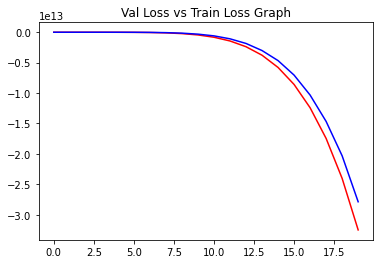

In [90]:
# summarize history for loss
plt.plot(history.history['val_loss'], color='r', label='Val Loss')
plt.plot(history.history['loss'], color='b', label='Train Loss')
plt.title('Val Loss vs Train Loss Graph')
plt.show()

In [91]:
model.save('content_based_model_new1.h5')

# Making Recommendations

In [92]:
# Creating dataset for making recommendations for the first user
hotel_data = np.array(list(set(total_data['label'])))
hotel_data[:5]

array([1, 2, 3, 4, 5])

In [93]:
user = np.array([1 for i in range(len(hotel_data))])
user[:5]

array([1, 1, 1, 1, 1])

In [113]:
sample_data_array = total_data.iloc[0:1, :]

In [117]:
sample_data_array_dense = [sample_data_array[f].values for f in dense_features]
sample_data_array_sparse = [sample_data_array[f].values for f in sparse_features]

In [115]:
sample_data_array_dense

[array([4.2]), array([35.9]), array([-78.8])]

In [118]:
sample_data_array_sparse

[array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([1]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([1]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([1]),
 array([0]),
 array([1]),
 array([0]),
 array([1]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([1]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([1]),
 array([0]),
 array([1]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),

In [124]:
sample_label = [sample_data_array.iloc[: , -1].values]
sample_label

[array([1])]

In [126]:
predictions = model.predict(sample_data_array_dense+sample_data_array_sparse, batch_size=32)

predictions = np.array([a[0] for a in predictions])

recommended_item_ids = (-predictions).argsort()[:5]

recommended_item_ids

1/1 [==============================] - 1s 530ms/step


array([0])

In [77]:
# print predicted scores
predictions[recommended_item_ids]

array([0.19043083, 0.18687372, 0.18581037, 0.18546915, 0.18278559],
      dtype=float32)

# Recommend Hotel Cluster for a User

In [99]:
rows = []
hotel = list(df.drop_duplicates(subset='Item_id', keep='first').Item_id)
names = list(df.drop_duplicates(subset='Item_id', keep='first').Item_id)

for i in range(len(hotel)):
    rows.append( dict({'name': names[i], 'Item_id' : hotel[i], 'User_id' : 1048}))
test_data = pd.DataFrame(rows)

In [100]:
for idx, (score, name) in enumerate(sorted(zip(recommended_item_ids, names), reverse=True)):
 
    print("Score: ", round(float(score), 2), " for hotel cluster: ", name)

Score:  72.0  for hotel cluster:  1
Score:  59.0  for hotel cluster:  21
Score:  49.0  for hotel cluster:  80
Score:  36.0  for hotel cluster:  41
Score:  19.0  for hotel cluster:  92


In [41]:
hotel_data = np.array(list(set(df['item'])))
hotel_data[:10]

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [42]:
id_user = 20
user = np.array([id_user for i in range (len(hotel_data))])
user[:10]

array([20, 20, 20, 20, 20, 20, 20, 20, 20, 20])

In [43]:
predictions = model.predict([user, hotel_data])
predictions = np.array([a[0] for a in predictions])
recommended_hotel_id = (-predictions).argsort()[:10]
recommended_hotel_id

45/45 [==============================] - 0s 5ms/step


array([  6,  83, 138,  21,  84,   4,  62, 115,  77,  34])

In [44]:
predictions[recommended_hotel_id]

array([4.595995 , 4.157644 , 3.9491413, 3.9372382, 3.914852 , 3.8839493,
       3.7683673, 3.7665148, 3.7572596, 3.6514044], dtype=float32)